<a href="https://colab.research.google.com/github/Priyamchamp/nueral-nets/blob/main/microsoft_stock_prediction_LSTMmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data


In [1]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/


In [ ]:
!pip install --upgrade pandas_datareader

In [2]:
import pandas as pd
df=pd.read_csv("/content/MSFT.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063503,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061888,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400
...,...,...,...,...,...,...,...
9536,2024-01-16,393.660004,394.029999,387.619995,390.269989,390.269989,27202300
9537,2024-01-17,387.980011,390.109985,384.809998,389.470001,389.470001,22234100
9538,2024-01-18,391.720001,393.989990,390.119995,393.869995,393.869995,23392100
9539,2024-01-19,395.760010,398.670013,393.500000,398.670013,398.670013,29272000


In [4]:
df=df[['Date','Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9536,2024-01-16,390.269989
9537,2024-01-17,389.470001
9538,2024-01-18,393.869995
9539,2024-01-19,398.670013


In [5]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9536    2024-01-16
9537    2024-01-17
9538    2024-01-18
9539    2024-01-19
9540    2024-01-22
Name: Date, Length: 9541, dtype: object

In [6]:
import datetime
#for changing the date type from string to int
def change_date(s):
  split=s.split('-')
  year,month,day=int(split[0]),int(split[1]),int(split[2])
  return datetime.datetime(year=year,month=month,day=day)

#applying th efunction

df['Date']=df['Date'].apply(change_date)

df['Date']

<ipython-input-6-e48bdb7d8681>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date']=df['Date'].apply(change_date)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9536   2024-01-16
9537   2024-01-17
9538   2024-01-18
9539   2024-01-19
9540   2024-01-22
Name: Date, Length: 9541, dtype: datetime64[ns]

In [7]:
df.index=df.pop('Date')


In [8]:
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-01-16,390.269989
2024-01-17,389.470001
2024-01-18,393.869995


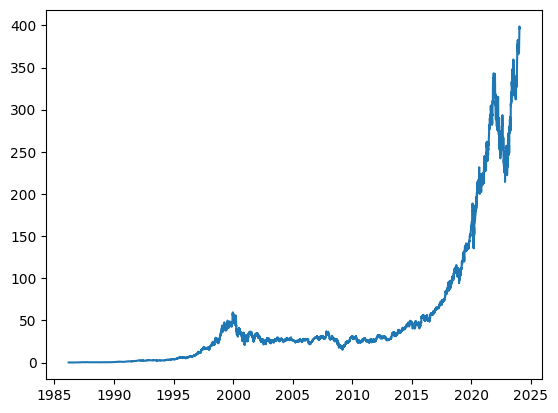

In [10]:
import matplotlib.pyplot as plt
plt.plot(df.index,df['Close'])

In [11]:
#creating a lstm model
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = change_date(first_date_str)
  last_date  = change_date(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [12]:
#creating the model matrix
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

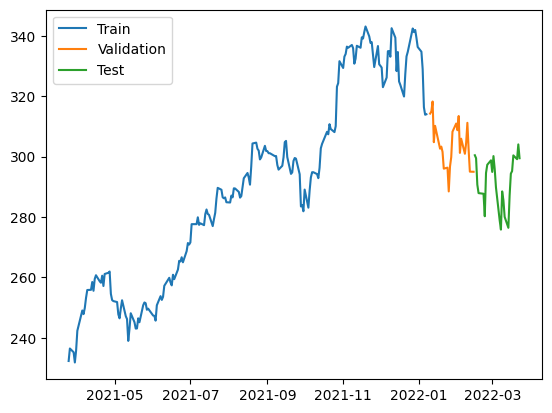

In [13]:
#training,valdiation datasets
q_80 = int(len(dates) * .8)#for first 80 percent
q_90 = int(len(dates) * .9)#for 90 percent

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [14]:
#creating the model using keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 5s 124ms/step - loss: 84169.0938 - mean_absolute_error: 288.3720 - val_loss: 91723.5781 - val_mean_absolute_error: 302.7715
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 83772.5000 - mean_absolute_error: 287.6846 - val_loss: 91323.1875 - val_mean_absolute_error: 302.1096
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 83378.7109 - mean_absolute_error: 287.0007 - val_loss: 90893.6172 - val_mean_absolute_error: 301.3978
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 82926.9375 - mean_absolute_error: 286.2096 - val_loss: 90303.5391 - val_mean_absolute_error: 300.4172
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 82243.1016 - mean_absolute_error: 285.0147 - val_loss: 89370.0391 - val_mean_absolute_error: 298.8595
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 81232.3359 - mean_absolute_error: 283.2296 - val_loss: 88

7/7 [==============================] - 1s 3ms/step


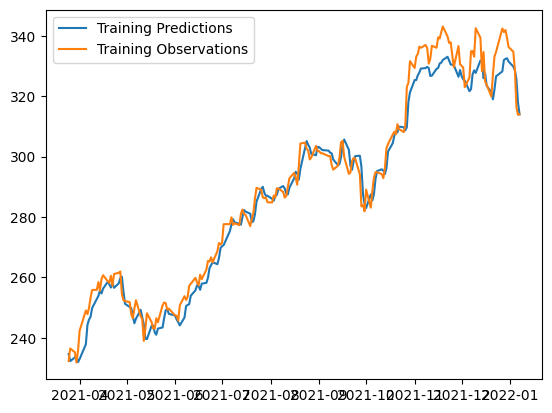

In [15]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 18ms/step


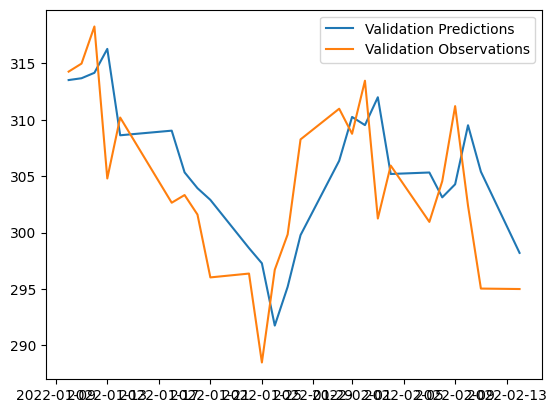

In [16]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 30ms/step


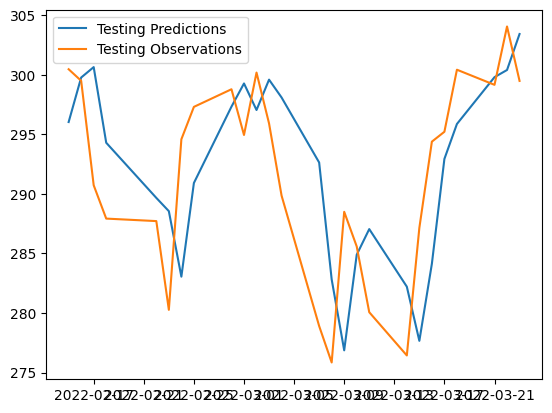

In [17]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

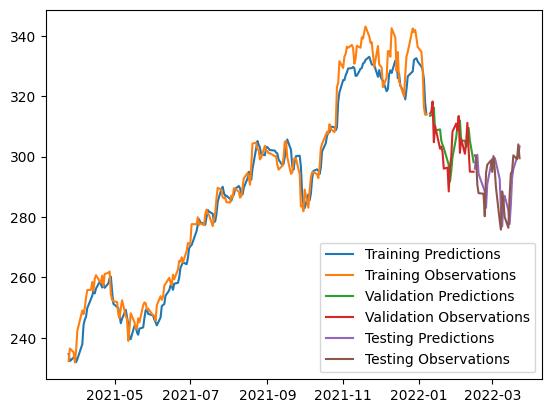

In [18]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

1/1 [==============================] - 0s 19ms/step
the red line in the graph shows that our model cant predict the stocks which is actually true as well as good as we cannot be predicitng the market only based on the curves


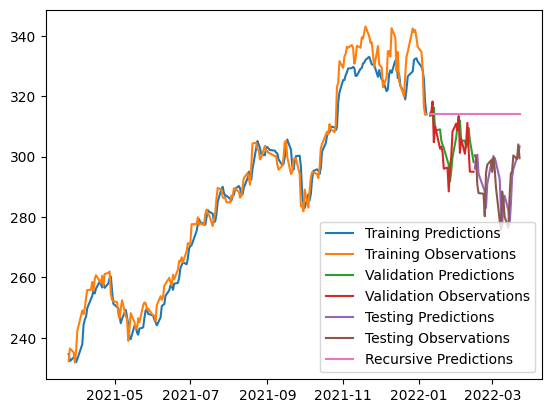

In [20]:
from copy import deepcopy
#predicting the future of the stocks
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
#predicitng functions
for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

#showing the graph

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

print("the red line in the graph shows that our model cant predict the stocks which is actually true as well as good as we cannot be predicitng the market only based on the curves")